# The Problem Statement:

The sequence identity of the COVID19 protease and that of SARS-CoV is high, hence by using the known SARS-CoV protease drugs generate possible drugs using machine learning methods to generate novel drug like candidates. Use a variational autoencoder with SMILES representation to generate novel molecules from the trained continuous latent space. The novel molecules shall be assessed based on SMART pattern matching, to rule out unlikely molecular structures e.g structures with multiple 3,4,7,8 membered rings, purely acyclic compounds, highly branched ones etc. Furthermore, diversity based on PubChem / MACCS fingerprints (tanimoto coefficients <= 0.60) shall also be assessed to make sure generated structures are significantly dissimilar to training set. Use multiple SARS-CoV-2 protease conformation to screen of generated chemicals using ensemble molecular docking protocol at both allosteric and orthosteric sites. Retain chemicals with best docking scores and binding energies as per the guidelines. Shortlist the top 100 or top 25% (max 100) hits and refine the best 10 using MD simulation without any restraints.

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
random.seed(24)

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem

def canonicalize(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

def validSMILES(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return True

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.cluster import KMeans

In [5]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [142]:
traindata = pd.read_csv('cleancovid19dataset.csv')

In [146]:
traindata['cleanSMILES'] = traindata['SMILES'].apply(canonicalize)

In [148]:
traindata['cleanSMILES']

0      CC[C@H]1C[C@@H](C(=O)Nc2cc(C)nn2-c2cccc(C(F)(F...
1      Nc1nc2nc(CN[C@H](Cc3ccccc3)[C@@H](O)C(F)(F)F)c...
2      Cc1cc(NC(=O)[C@H]2CC(=O)Nc3cc(F)ccc32)n(-c2ccc...
3      CC[C@@H]1C[C@@H](C(=O)Nc2cc(C)nn2-c2cccc(Br)c2...
4      CC[C@@H]1C[C@@H](C(=O)NC2(CNC(=O)c3ccn[nH]3)CC...
                             ...                        
668            CC1(C)NC(=O)Cc2cc(-c3c(F)cc(CO)cc3F)ccc21
669    C[C@@H](O)[C@@H](NC(=O)[C@@](C)(O)c1ccccc1)c1c...
670           Cc1csc(C2(NC(=O)C[C@H]3CCCCC(=O)N3)CCC2)n1
671       Cn1cc(NC(=O)c2c[nH]c(=O)c(Br)c2)c(-c2ccccc2)n1
672            Cc1cc(CO)cc(Nc2nc(N(C)C)[nH]c(=O)c2N=O)c1
Name: cleanSMILES, Length: 673, dtype: object

In [149]:
data = list(zip(traindata['cleanSMILES'],traindata['cleanSMILES']))


In [150]:
data

[('CC[C@H]1C[C@@H](C(=O)Nc2cc(C)nn2-c2cccc(C(F)(F)F)c2)CC(=O)N1',
  'CC[C@H]1C[C@@H](C(=O)Nc2cc(C)nn2-c2cccc(C(F)(F)F)c2)CC(=O)N1'),
 ('Nc1nc2nc(CN[C@H](Cc3ccccc3)[C@@H](O)C(F)(F)F)cc(=O)n2[nH]1',
  'Nc1nc2nc(CN[C@H](Cc3ccccc3)[C@@H](O)C(F)(F)F)cc(=O)n2[nH]1'),
 ('Cc1cc(NC(=O)[C@H]2CC(=O)Nc3cc(F)ccc32)n(-c2cccc(Cl)c2)n1',
  'Cc1cc(NC(=O)[C@H]2CC(=O)Nc3cc(F)ccc32)n(-c2cccc(Cl)c2)n1'),
 ('CC[C@@H]1C[C@@H](C(=O)Nc2cc(C)nn2-c2cccc(Br)c2)CC(=O)N1',
  'CC[C@@H]1C[C@@H](C(=O)Nc2cc(C)nn2-c2cccc(Br)c2)CC(=O)N1'),
 ('CC[C@@H]1C[C@@H](C(=O)NC2(CNC(=O)c3ccn[nH]3)CCC2)CC(=O)N1',
  'CC[C@@H]1C[C@@H](C(=O)NC2(CNC(=O)c3ccn[nH]3)CCC2)CC(=O)N1'),
 ('Cc1cc(NC(=O)[C@H]2CC(=O)N[C@H](C)C2)n(-c2cccc(Br)c2)n1',
  'Cc1cc(NC(=O)[C@H]2CC(=O)N[C@H](C)C2)n(-c2cccc(Br)c2)n1'),
 ('Cn1cc(-c2cc(F)ccc2NC(=O)[C@H]2CC(=O)Nc3cc(F)ccc32)cn1',
  'Cn1cc(-c2cc(F)ccc2NC(=O)[C@H]2CC(=O)Nc3cc(F)ccc32)cn1'),
 ('C[C@H]1C[C@@H](C(=O)NC2(c3ccc(OC(F)(F)F)cc3)CC2)CC(=O)N1',
  'C[C@H]1C[C@@H](C(=O)NC2(c3ccc(OC(F)(F)F)cc3)CC2)CC(=O)N1')

We clean up the similes strings into stuff that can be fed into the LSTM
#use content from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [151]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_chars = 3  # Count SOS and EOS and PAD

    def addSMILES(self, smiles):
        for char in smiles:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [152]:
max([len(smiles) for smiles in traindata['cleanSMILES'] ])

63

In [153]:
MIN_LENGTH = 3
MAX_LENGTH = 63

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

In [154]:
def prepareData(lang1, lang2, data):
    """takes data as list of pairs for now
    returns the dictionaries for input and output languages, and the pairs"""
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    pairs = data
    print("Read %s smiles pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Counting chars...")
    for pair in pairs:
        input_lang.addSMILES(pair[0])
        output_lang.addSMILES(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

In [159]:
#input_lang, output_lang, pairs = prepareData("Random SMILES","Canonical SMILES", data)
input_lang, output_lang, pairs = prepareData("Canonical SMILES","Canonical SMILES", data)
print(random.choice(pairs))

Read 673 smiles pairs
Filtered to 673 pairs
Counting chars...
Counted chars:
Canonical SMILES 30
Canonical SMILES 30
('Cc1cccc(C2(NC(=O)c3cc(=O)n4[nH]cnc4n3)CCCC2)c1', 'Cc1cccc(C2(NC(=O)c3cc(=O)n4[nH]cnc4n3)CCCC2)c1')


In [160]:
len(pairs)

673

In [161]:
testpairs = pairs[500:]

In [162]:
pairs = pairs[0:500]

How do we deal with this problem that the languages are different?

In [163]:
len(pairs)

500

# Model code
Now we implement the seq-to-vec part

In [164]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

In [165]:
class VAE(nn.Module):
    def __init__(self,hidden_size, lat_int_size = 60, lat_size = 30):
        super(VAE, self).__init__()
        self.hidden_size = hidden_size
        self.lat_int_size = lat_int_size
        self.lat_size = lat_size
        self.fc1 = nn.Linear(hidden_size, lat_int_size)
        self.fc21 = nn.Linear(lat_int_size, lat_size)
        self.fc22 = nn.Linear(lat_int_size, lat_size)
        self.fc3 = nn.Linear(lat_size, lat_int_size)
        self.fc4 = nn.Linear(lat_int_size, hidden_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        #mu, logvar = self.encode(x.view(-1, hidden_size))
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [166]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()

        # Keep for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, last_hidden):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        output, hidden = self.gru(embedded, last_hidden)
        output = self.out(output)

        # Return final output, hidden state
        return output, hidden

## Dealing with variable length sequences

In [167]:
def indexesFromSmiles(lang, smiles):
    return [lang.char2index[char] for char in smiles] + [EOS_token]


def tensorFromSmiles(lang, smiles):
    indexes = indexesFromSmiles(lang, smiles)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq


In [168]:
def random_batch(batch_size, whichpairs):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(whichpairs)
        input_seqs.append(indexesFromSmiles(input_lang, pair[0]))
        target_seqs.append(indexesFromSmiles(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs) 
    """the * unzips"""
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1).to(device)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1).to(device)
        
    return input_var, input_lengths, target_var, target_lengths

In [169]:
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long() #note arange is [) unlike torch.range which is []
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

## Testing the model

In [170]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size, pairs)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([51, 3])
target_batches torch.Size([51, 3])


In [171]:
small_hidden_size = 8
small_n_layers = 1
small_latent_int_size = 10
small_lat_size = 5

encoder_test = EncoderRNN(input_lang.n_chars, small_hidden_size, small_n_layers).to(device)
vae_test = VAE(small_hidden_size,small_latent_int_size, small_lat_size).to(device)
decoder_test = DecoderRNN(small_hidden_size, output_lang.n_chars, small_n_layers).to(device)



In [172]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([51, 3, 8])
encoder_hidden torch.Size([2, 3, 8])


In [173]:
encoder_hidden[:decoder_test.n_layers].shape

torch.Size([1, 3, 8])

In [174]:
new_hidden, mu, logvar = vae_test(encoder_hidden[:decoder_test.n_layers])

print('new_hidden size', new_hidden.size())
print('mu_shape', mu.shape)

new_hidden size torch.Size([1, 3, 8])
mu_shape torch.Size([1, 3, 5])


In [175]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size)).to(device)
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size)).to(device)

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden = decoder_test(decoder_input, decoder_hidden)
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss

loss = masked_cross_entropy(all_decoder_outputs.transpose(0, 1).contiguous(),
                            target_batches.transpose(0, 1).contiguous(),
                           target_lengths)
print('loss', loss.item())

loss 3.369860887527466


/home/julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [176]:
Variable(torch.LongTensor(target_lengths))

tensor([51, 48, 39])

## Evaluation code

In [177]:
def validation_loss(input_batches, input_lengths, target_batches, target_lengths,\
          encoder,vae, decoder, max_length=MAX_LENGTH):
    
    with torch.no_grad():
        val_loss = 0 # Added onto for each word
        # Run words through encoder
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
        
        # run hidden vector through vae, also get the mu and logvar
        new_hidden, mu, logvar = vae(encoder_hidden[:decoder.n_layers])

        # Prepare input and output variables
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).to(device)
        decoder_hidden = new_hidden
        # Use last (forward) hidden state from encoder

        max_target_length = max(target_lengths)
        all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size)).to(device)



        # Run through decoder one time step at a time
        for t in range(max_target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target (this is teacher forcing?)

        # Loss calculation and backpropagation
        recon_loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths
        )

        #apparently this is the analytical solution for KL divergence of gaussians
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + 0.0001*kl_loss
        #print("recon loss: ", recon_loss, "and kl loss:", kl_loss)
        return loss.item()


In [178]:
def evaluate(encoder,vae,decoder,input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexesFromSmiles(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1).to(device)
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    #run through vae
    new_hidden, mu, logvar = vae(encoder_hidden[:decoder.n_layers])

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token])).to(device) # SOS
    decoder_hidden = new_hidden
    # Use last (forward) hidden state from encoder

    # Store output words and attention states
    decoded_chars = []
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()
        #print("ni",ni)
        if ni == EOS_token:
            #decoded_chars.append('<EOS>') there's no point adding it, just screws up rdkit
            break
        else:
            decoded_chars.append(output_lang.index2char[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni])).to(device)
        

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return ''.join(decoded_chars)

In [179]:
def evaluateRandomly(encoder,vae, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('original smiles', pair[0])
        print('actual canonical SMILES', pair[1])
        output_smiles = evaluate(encoder,vae, decoder, pair[0])
        print('predicted canonical SMILES', output_smiles)
        print('')
        
evaluateRandomly(encoder_test,vae_test,decoder_test)        
evaluate(encoder_test,vae_test,decoder_test,'CCCO')

def quality(encoder,vae,decoder, n=20):
    valids = 0
    for i in range(n):
        pair = random.choice(pairs)
        output_smiles = evaluate(encoder,vae, decoder, pair[0])
        if validSMILES(output_smiles):
            valids +=1
            print('predicted canonical SMILES', output_smiles, 'n: ',i)
    print("Fraction of valid SMILES is: ",valids/n)
        
quality(encoder_test,vae_test, decoder_test)



original smiles COc1ccc(C2(NC(=O)[C@H]3CC(=O)N[C@H](C)C3)CCCC2)cc1
actual canonical SMILES COc1ccc(C2(NC(=O)[C@H]3CC(=O)N[C@H](C)C3)CCCC2)cc1
predicted canonical SMILES 

original smiles C[C@@H]1CCCN(Cc2cc(=O)n3[nH]c(N)nc3n2)c2ccccc21
actual canonical SMILES C[C@@H]1CCCN(Cc2cc(=O)n3[nH]c(N)nc3n2)c2ccccc21
predicted canonical SMILES 

original smiles C[C@H]1C[C@@H](C(=O)NC2(c3ccc(C(C)(C)C)cc3)CCCC2)CC(=O)N1
actual canonical SMILES C[C@H]1C[C@@H](C(=O)NC2(c3ccc(C(C)(C)C)cc3)CCCC2)CC(=O)N1
predicted canonical SMILES 

original smiles O=C(/C=C\c1ccc[nH]1)N[C@H](CO)CNC(=O)c1cc(F)c[nH]1
actual canonical SMILES O=C(/C=C\c1ccc[nH]1)N[C@H](CO)CNC(=O)c1cc(F)c[nH]1
predicted canonical SMILES 

original smiles Cn1cc(NC(=O)N[C@H]2CCC(=O)N[C@@H]2C2CC2)c(-c2ccco2)n1
actual canonical SMILES Cn1cc(NC(=O)N[C@H]2CCC(=O)N[C@@H]2C2CC2)c(-c2ccco2)n1
predicted canonical SMILES ]

predicted canonical SMILES  n:  0
predicted canonical SMILES  n:  1
predicted canonical SMILES  n:  2
predicted canonical SMILES  

RDKit ERROR: [02:50:18] SMILES Parse Error: syntax error while parsing: ]
RDKit ERROR: [02:50:18] SMILES Parse Error: Failed parsing SMILES ']' for input: ']'
RDKit ERROR: [02:50:18] SMILES Parse Error: syntax error while parsing: ]
RDKit ERROR: [02:50:18] SMILES Parse Error: Failed parsing SMILES ']' for input: ']'


In [180]:
output_lang.index2char

{0: 'PAD',
 1: 'SOS',
 2: 'EOS',
 3: 'C',
 4: '[',
 5: '@',
 6: 'H',
 7: ']',
 8: '1',
 9: '(',
 10: '=',
 11: 'O',
 12: ')',
 13: 'N',
 14: 'c',
 15: '2',
 16: 'n',
 17: '-',
 18: 'F',
 19: '3',
 20: 'l',
 21: 'B',
 22: 'r',
 23: '4',
 24: 'o',
 25: 'S',
 26: 's',
 27: '/',
 28: '#',
 29: '\\'}

## Training code

In [181]:
def train(input_batches, input_lengths, target_batches, target_lengths,\
          encoder,vae, decoder, encoder_optimizer,vae_optimizer, decoder_optimizer,\
          max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    vae_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # run hidden vector through vae, also get the mu and logvar
    new_hidden, mu, logvar = vae(encoder_hidden[:decoder.n_layers])
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).to(device)
    decoder_hidden = new_hidden
    # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size)).to(device)

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target (this is teacher forcing?)

    # Loss calculation and backpropagation
    recon_loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    
    #apparently this is the analytical solution for KL divergence of gaussians
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    loss = recon_loss + 0.0001*kl_loss #had to reduce the weight give to the KL 
    #to prevent it from making every single molecule the same
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    vc = torch.nn.utils.clip_grad_norm_(vae.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    
    # Update parameters with optimizers
    encoder_optimizer.step()
    vae_optimizer.step()
    decoder_optimizer.step()
    #print("recon loss: ", recon_loss, "and kl loss:", kl_loss)
    return loss.item()


In [182]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [183]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Actual training

## Loading a saved model

In [184]:
# Configure models
hidden_size = 300
lat_int_size = 300
lat_size = 300
n_layers = 1

encoder = EncoderRNN(input_lang.n_chars, hidden_size, n_layers=1).to(device)
vae = VAE(hidden_size, lat_int_size, lat_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_chars, n_layers=1).to(device)

from pathlib import Path
savedencoderfile = "SMILESencoder300.pt"
savedvaefile = "SMILESvae300.pt"
saveddecoderfile = "SMILESdecoder300.pt"
if Path(savedencoderfile).is_file():
    # file exists
    encoder.load_state_dict(torch.load(savedencoderfile))
    #model.eval() wtf is this
    print("=== Encoder was loaded from " + savedencoderfile)
    
if Path(savedvaefile).is_file():
    # file exists
    vae.load_state_dict(torch.load(savedvaefile))
    #model.eval() wtf is this
    print("=== Encoder was loaded from " + savedvaefile)
    
if Path(saveddecoderfile).is_file():
    # file exists
    decoder.load_state_dict(torch.load(saveddecoderfile))
    #model.eval() wtf is this
    print("=== Decoder was loaded from " + saveddecoderfile)

    

In [185]:
evaluate(encoder,vae, decoder, 'CCCOC')

'HOcc##l#(occ##l##=2/SOS##=l2(occc##l##=2/SOS##=l2(occc##l##=2/SOS##=l'

In [186]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.001
decoder_learning_ratio = 5.0


plot_every = 50
print_every = 50
n_epochs = 500

batch_size = 100

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

In [187]:
# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
test_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every
epoch = 0
while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, pairs)

    # Run the train function
    loss= train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder,vae, decoder,
        encoder_optimizer,vae_optimizer, decoder_optimizer
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    
    #job.record(epoch, loss)

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),\
                                               epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size, testpairs)
        test_loss = validation_loss(input_batches, input_lengths, target_batches, target_lengths,\
                                    encoder,vae, decoder)
        test_losses.append(test_loss)

/home/julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2m 0s (- 18m 6s) (50 10%) 0.9799
3m 54s (- 15m 39s) (100 20%) 0.4733
5m 48s (- 13m 32s) (150 30%) 0.3331
7m 41s (- 11m 32s) (200 40%) 0.2669
9m 35s (- 9m 35s) (250 50%) 0.2262
11m 29s (- 7m 39s) (300 60%) 0.2024
13m 22s (- 5m 43s) (350 70%) 0.1889
15m 12s (- 3m 48s) (400 80%) 0.1787
17m 2s (- 1m 53s) (450 90%) 0.1725
18m 53s (- 0m 0s) (500 100%) 0.1661


In [188]:
evaluateRandomly(encoder,vae,decoder)

original smiles C[C@H]1C[C@@H](C(=O)Nc2ccc(Cl)cc2O)CC(=O)N1
actual canonical SMILES C[C@H]1C[C@@H](C(=O)Nc2ccc(Cl)cc2O)CC(=O)N1
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1

original smiles CC[C@H](CNC(=O)c1ccc[nH]1)NC(=O)c1cc2c([nH]1)CCC2
actual canonical SMILES CC[C@H](CNC(=O)c1ccc[nH]1)NC(=O)c1cc2c([nH]1)CCC2
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1

original smiles O=C1C[C@H](C(=O)N[C@H]2CCCC[C@H]2O)c2ccc(F)cc2N1
actual canonical SMILES O=C1C[C@H](C(=O)N[C@H]2CCCC[C@H]2O)c2ccc(F)cc2N1
predicted canonical SMILES O=C(Cc1ccc(O)c(F)c1)N[C@@H]1CCCc2c1cnn2CCO

original smiles O=C1CC[C@H](CC(=O)N2CCCC[C@H](NC(=O)C3CC=CC3)C2)N1
actual canonical SMILES O=C1CC[C@H](CC(=O)N2CCCC[C@H](NC(=O)C3CC=CC3)C2)N1
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1

original smiles CSc1cc(-c2cn(C)c(=O)c3ccccc23)cc(C(F)(F)F)c1
actual canonical SMILES CSc1cc(-c2cn(C)c(=O)c3ccccc23)cc(C(F)(F)F)c1
predicte

<Figure size 432x288 with 0 Axes>

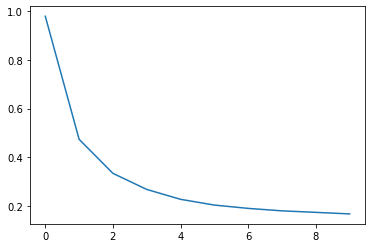

<Figure size 432x288 with 0 Axes>

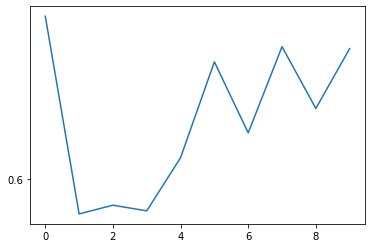

In [189]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)
show_plot(test_losses)

In [190]:
evaluate(encoder,vae, decoder, "CCCO")

'CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1'

In [191]:
quality(encoder,vae,decoder, 50)

predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  0
predicted canonical SMILES O=C(Cc1ccc(O)c(F)c1)N[C@@H]1CCCc2c1cnn2CCO n:  1
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  2
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  3
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  4
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  5
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  6
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  7
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  8
predicted canonical SMILES O=C(Cc1ccc(O)c(F)c1)N[C@@H]1CCCc2c1cnn2CCO n:  9
predicted canonical SMILES O=C(Cc1ccc(O)c(F)c1F)[C@H](O)[C@@H](O)c1nc2ccccc2[nH]1 n:  10
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)

In [192]:
def trainedpics(encoder,vae,decoder,n=10):
    ms = []
    for i in range(n):
        pair = random.choice(pairs)
        output_smiles = evaluate(encoder,vae, decoder, pair[0])
        if validSMILES(output_smiles):
            ms.append(Chem.MolFromSmiles(output_smiles))
            print('predicted canonical SMILES', output_smiles, 'n: ',i)
    return ms


    

predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  0
predicted canonical SMILES CC(C)[C@H](CNC(=O)c1cc(C#N)c[nH]1)NC(=O)c1cc2occc2[nH]1 n:  1
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  2
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  3
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  4
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  5
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  6
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  7
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  8
predicted canonical SMILES CC[C@H]1C[C@@H](C(=O)NC2(c3ccc(Cl)cc3)CCCC2)CC(=O)N1 n:  9


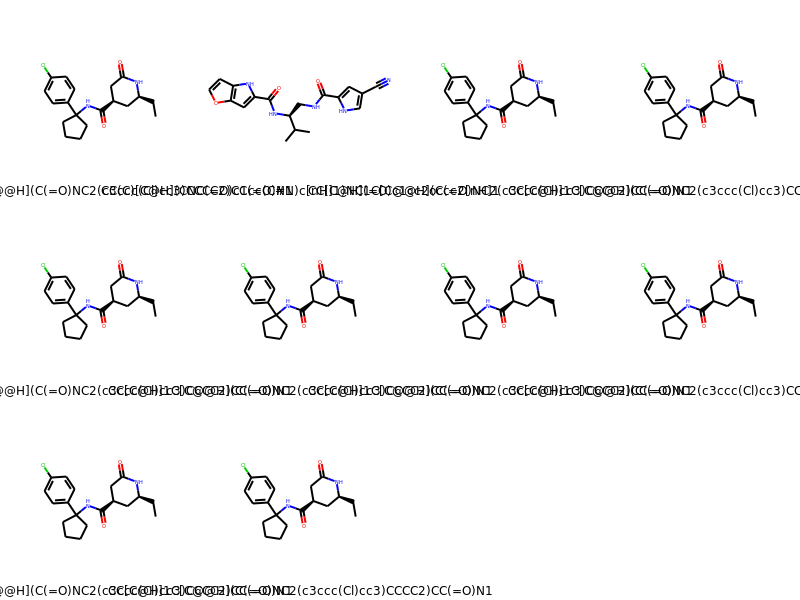

In [193]:
ms = trainedpics(encoder,vae,decoder)
Draw.MolsToGridImage(ms,molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms])

In [194]:
any(traindata['cleanSMILES'] == 'CN(CCCl)CCCl')

False

# Saving the model

In [195]:
torch.save(encoder.state_dict(), savedencoderfile)
torch.save(vae.state_dict(), savedvaefile)
torch.save(decoder.state_dict(), saveddecoderfile)
print("Model was saved as ",savedencoderfile, "and",savedvaefile,"and", saveddecoderfile )

Model was saved as  SMILESencoder300.pt and SMILESvae300.pt and SMILESdecoder300.pt


# Sampling from the model

In [196]:
def randomSample(vae,decoder):
    #get random hidden vector from the p(x/z) distribution
    new_hidden = vae.decode(torch.randn(1,1,vae.lat_size).to(device))
    
    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token])).to(device) # SOS
    decoder_hidden = new_hidden
    # Use last (forward) hidden state from encoder

    # Store output words and attention states
    decoded_chars = []
    
    # Run through decoder
    for di in range(MAX_LENGTH):
        decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()
        #print("ni",ni)
        if ni == EOS_token:
            #decoded_chars.append('<EOS>') there's no point adding it, just screws up rdkit
            break
        else:
            decoded_chars.append(output_lang.index2char[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni])).to(device)

        
    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return ''.join(decoded_chars)

def samplepics(encoder,vae,decoder,n=10):
    sms = []
    ms = []
    for i in range(n):
        output_smiles = randomSample(vae,decoder)
        if validSMILES(output_smiles):
            sms.append(output_smiles)
            ms.append(Chem.MolFromSmiles(output_smiles))
            #print('generated canonical SMILES', output_smiles, 'n: ',i)
    return ms, sms

In [197]:
ms, sms = samplepics(encoder,vae,decoder,100)

In [198]:
len(set(sms))

4

## Sample Quality Control

We check tanimoto similarity with molecules in the dataset

In [205]:
def diversemol(smiles, dataset, level):
    mol = Chem.MolFromSmiles(smiles)
    fpmol = Chem.RDKFingerprint(mol)
    for datasmiles in dataset:
        datamol = Chem.MolFromSmiles(datasmiles)
        fpdatamol = Chem.RDKFingerprint(datamol)
        if DataStructs.TanimotoSimilarity(fpmol, fpdatamol) >= level:
            return False
    return True

In [206]:
[m for m in set(sms) if diversemol(m,traindata['cleanSMILES'], 0.6)]

['O=C(Cc1ccc(O)c(F)c1F)[C@H](O)[C@@H](O)c1nc2ccccc2[nH]1']

What we have above is the list of molecules with tanimoto similarity less than 60% to the dataset

# References

https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

In [134]:
if __name__ == "__main__":
    print("The model will generate a random set of SMILES strings of potential SARS CoV 2 inhibitors")
    
    # do trained scripty stuff